In [1]:
library("tidyverse")
library("DESeq2")
library("pheatmap")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’

# Data import
We read in a count matrix, which we will name `cts`, and the sample information table, which we will name `coldata`.

In [2]:
# Define the counts matrix
cts <- read.csv(file = "data/PDAC_MICRODISSEC_NAIF/StarFCGeneCount_s408.tsv",
                sep = "\t", row.names = 1) |>
  as.matrix()

# Define the sample information table
coldata <- read.csv(file = "data/PDAC_MICRODISSEC_NAIF/StarMetrics_s408.tsv",
                    sep = "\t", row.names = 1)

## Filter out low expressed genes then filter out samples with low counts

In [3]:
# Remove the genes with more than 50% of the samples have 0 counts
cts <- cts[rowSums(cts == 0) < ncol(cts) * 0.5, ]

# Then remove the samples with more than 50% of the genes have 0 counts
cts <- cts[, colSums(cts == 0) < nrow(cts) * 0.5]

# Readjust the sample information table to match the filtered counts matrix
coldata <- coldata[colnames(cts), ]

# Load the immuno counts data extracted from the vst counts

In [4]:
# load the immuno counts data
immuno_counts <- read.csv("data/PDAC_MICRODISSEC_NAIF/results/immuno_counts.csv",
                          row.names = 1)

# Load the correlations data between immune cell counts and the gene counts
correlations <- read.csv("data/PDAC_MICRODISSEC_NAIF/results/correlations.csv",
                         row.names = 1)

## Include only the marisome genes 
Using `Hs Matrisome Masterlist 2012` list we study the correlation between the immuno cells counts and the matrisome genes

In [22]:
# Load the gene annotations table
geneannot <- read.delim("data/PDAC_MICRODISSEC_NAIF/geneAnnot.tsv", sep = "\t")

# Transform the gene ids into gene symbols using the annotation table
gene_symbols <- geneannot$GeneName[match(rownames(cts), geneannot$GeneID)]

# Load the matrisome genes list
matrisome_genes <- read.csv("Hs_Matrisome_Masterlist_2012.csv")

# Take the correlation of the matrisome genes with the immune cell types
correlations_matrisome <- correlations[match(matrisome_genes$Gene.Symbol,
                                             gene_symbols) |> na.omit(), ]

In [6]:
# Compute points that divide the immune cell counts into 4 quartiles
immuno_quartiles <- apply(X = immuno_counts,
                          MARGIN = 2,
                          FUN = quantile,
                          probs = c(0.25, 0.75)) |>
  as.data.frame()

# Add the immuno counts quartiles as a factor to the sample information table
for (celltype in colnames(immuno_counts)) {
  # Define breaks and factor levels
  breaks <- c(-Inf,
              immuno_quartiles["25%", celltype],
              immuno_quartiles["75%", celltype],
              Inf)

  # Add the factor to the coldata using cut
  coldata[[celltype]] <- cut(immuno_counts[[celltype]],
                             breaks = breaks,
                             labels = c("low", "normal", "high"))
}

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4323 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4589 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4447 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
--

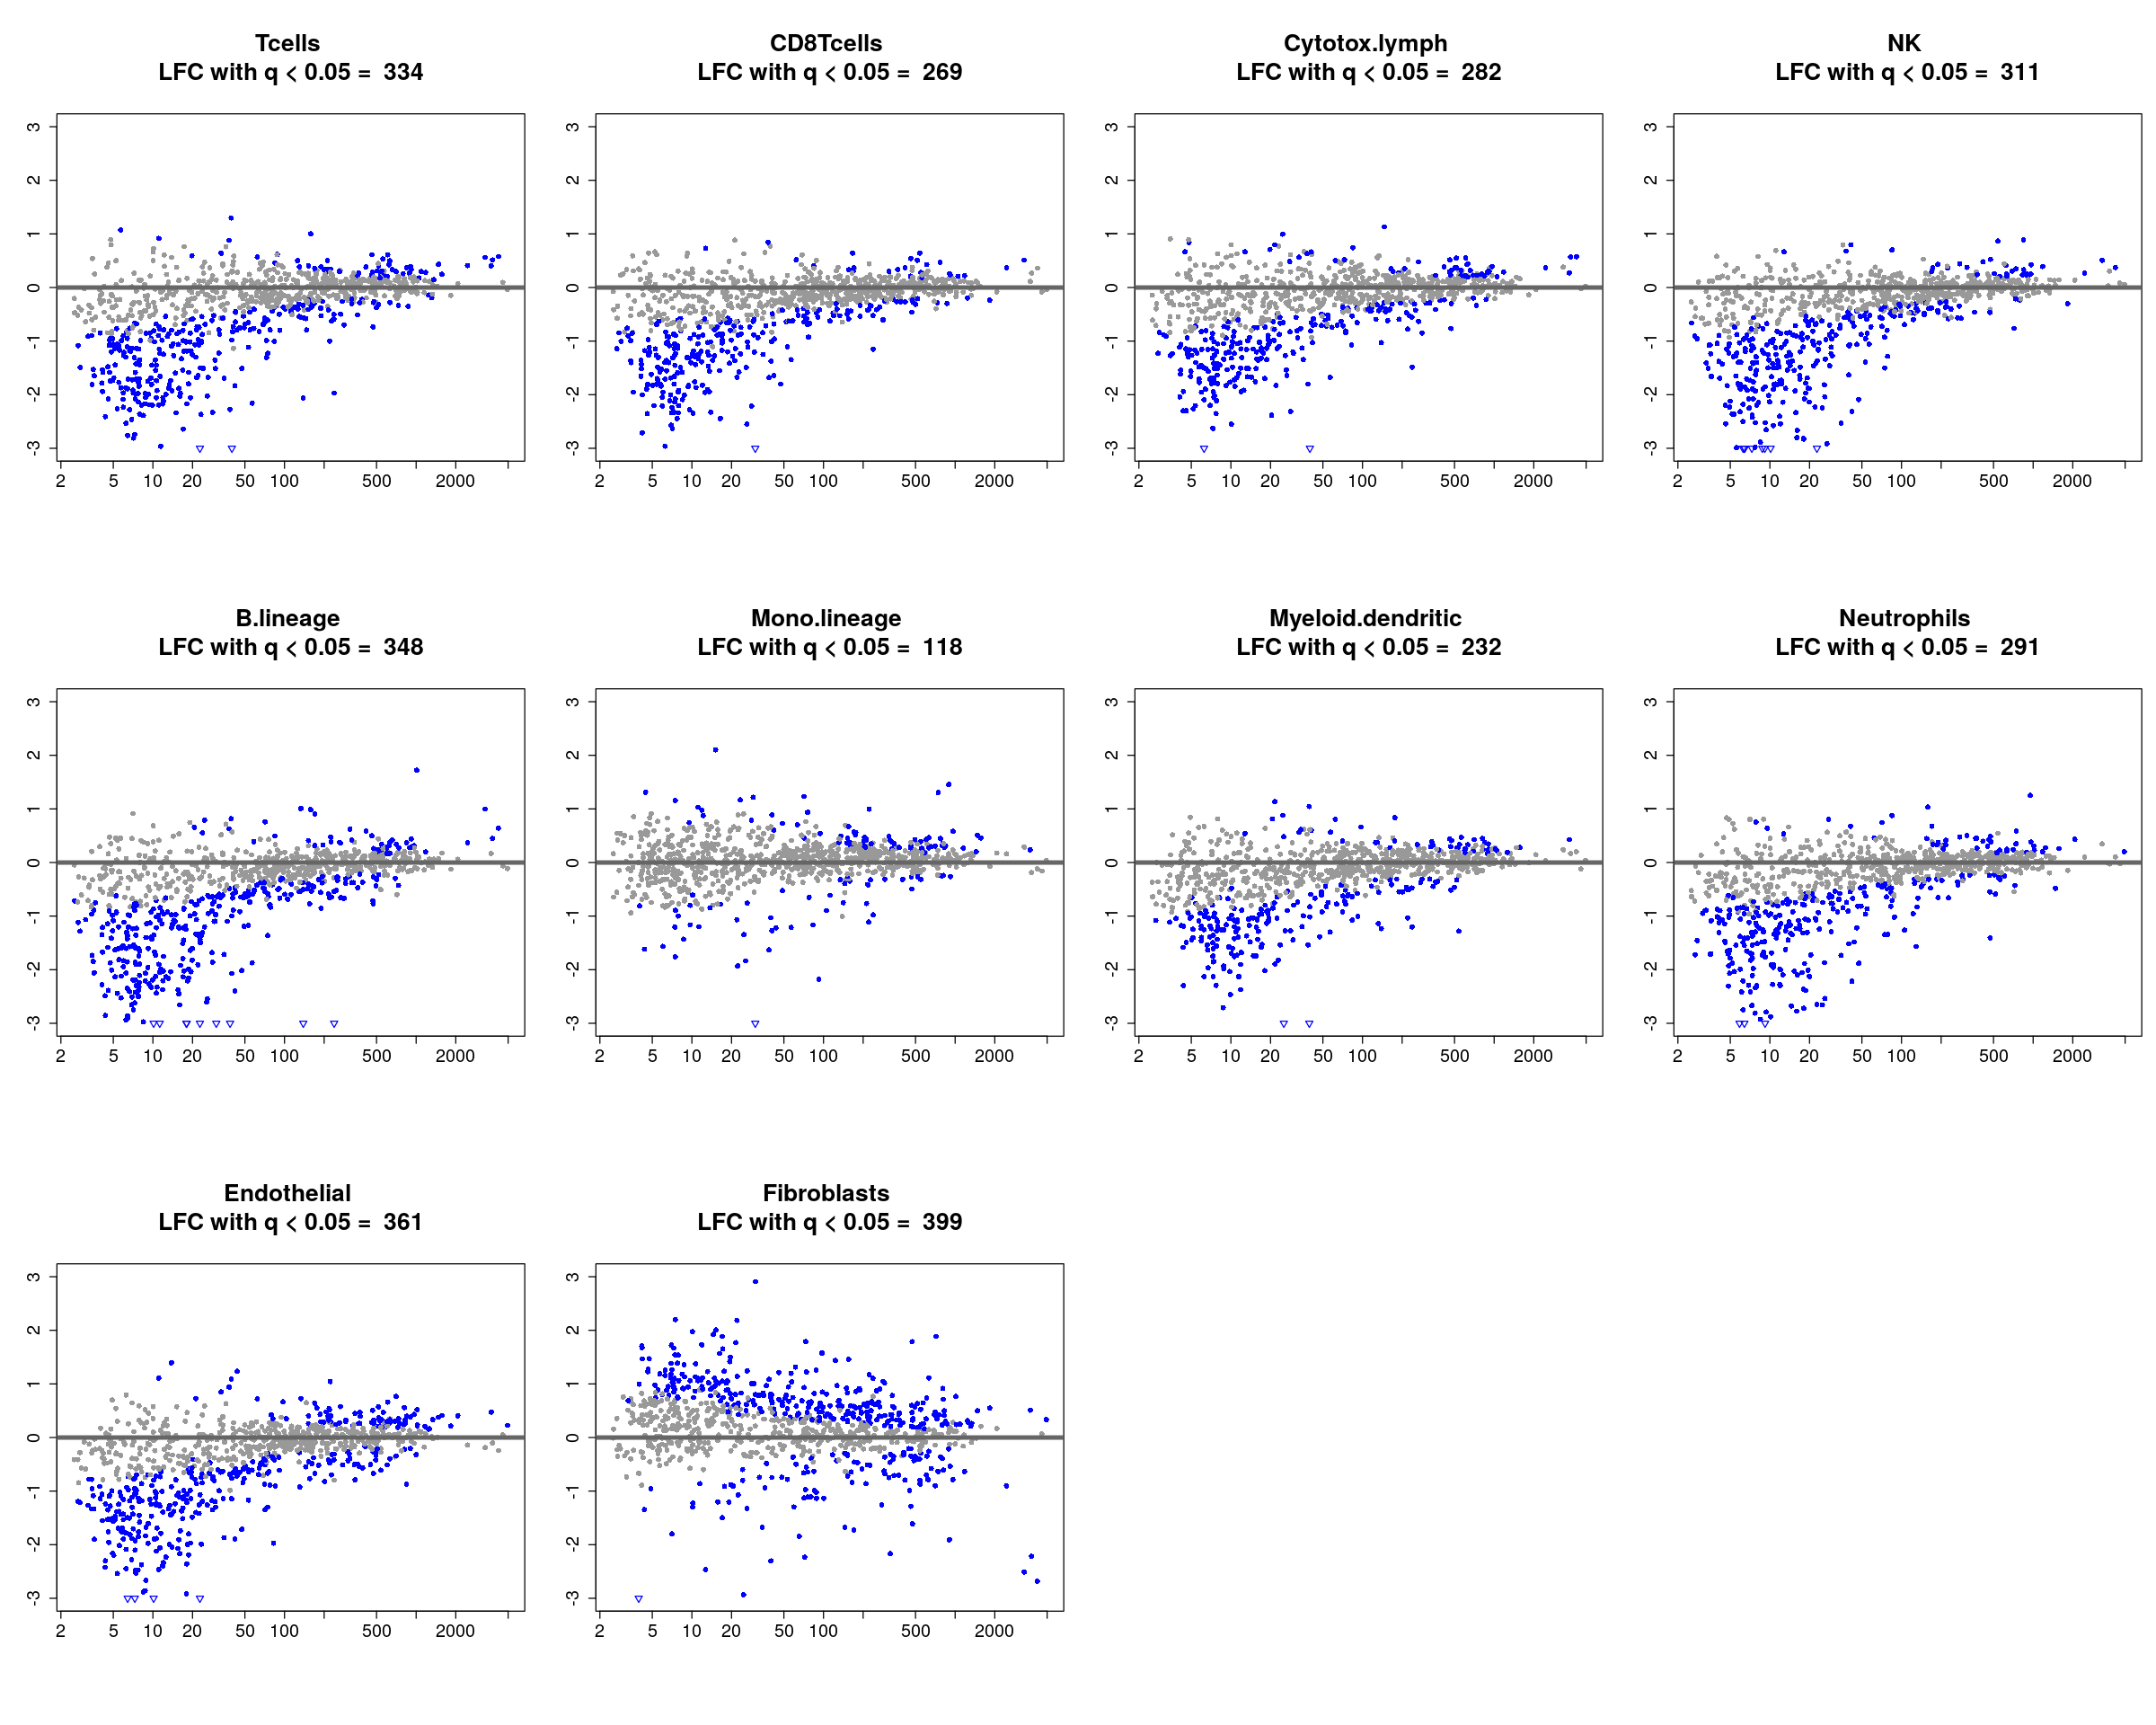

In [7]:
# plot the top 10 genes for each immune cell type
options(repr.plot.width = 20, repr.plot.height = 16)
par(mfrow = c(3, 4), mar = c(8, 4, 8, 1))

# Get the genes id
genes_id <- rownames(cts[match(matrisome_genes$Gene.Symbol,
                               gene_symbols) |> na.omit(), ])

# Create empty data frame with row names
res_all <- data.frame(matrix(ncol = 0, nrow = length(genes_id)))
rownames(res_all) <- genes_id

# Loop over the immune cell types
for (celltype in colnames(immuno_counts)) {
  # Define the DESeq2 dataset
  dds <- DESeqDataSetFromMatrix(countData = cts,
                                colData = coldata,
                                design = as.formula(paste("~", celltype)))

  # Remove the genes with less than 1000 counts
  dds <- dds[rowSums(counts(dds)) > 1000, ]

  # Remove the samples with less than 1000 counts
  dds <- dds[, colSums(counts(dds)) > 1000]

  # Run the DESeq2 analysis
  dds <- DESeq(dds)

  # Exclude the non matrisome genes in the dds object
  dds <- dds[match(matrisome_genes$Gene.Symbol, gene_symbols) |> na.omit(), ]

  # Get the results
  res <- dds |>
    results(contrast = c(celltype, "low", "high"), alpha = 0.05)

  # Count the number of genes differntially expressed with adjusted p-value < 0.05
  n_regulated_genes <- sum(res$padj < 0.05, na.rm = TRUE)

  # take the log2FoldChange, pvalue and padj columns
  res1 <- res |>
    as.data.frame() |>
    dplyr::select(log2FoldChange, pvalue, padj)

  # Add the celltype to the name of the columns
  res1 <- res1 |>
    dplyr::rename_with(~ paste0(., "_", celltype))

  # Add the res1 to the res_all data frame
  res_all <- cbind(res_all, res1)

  # Plot the MA plot
  res |>
    plotMA(alpha = 0.05,
           main = paste(celltype, "\nLFC with q < 0.05 = ", n_regulated_genes),
           cex = 1,
           cex.axis = 1,
           cex.main = 2,
           ylab = "",
           ylim = c(-3, 3))
}

In [8]:
# Extract the columns with the log2FoldChange values
lfcs <- res_all[seq(1, length(colnames(res_all)), 3)]
pvalues <- res_all[seq(2, length(colnames(res_all)), 3)]
padjs <- res_all[seq(3, length(colnames(res_all)), 3)]

# Rename the columns with the immune cell types
colnames(lfcs) <- colnames(immuno_counts)
colnames(pvalues) <- colnames(immuno_counts)
colnames(padjs) <- colnames(immuno_counts)

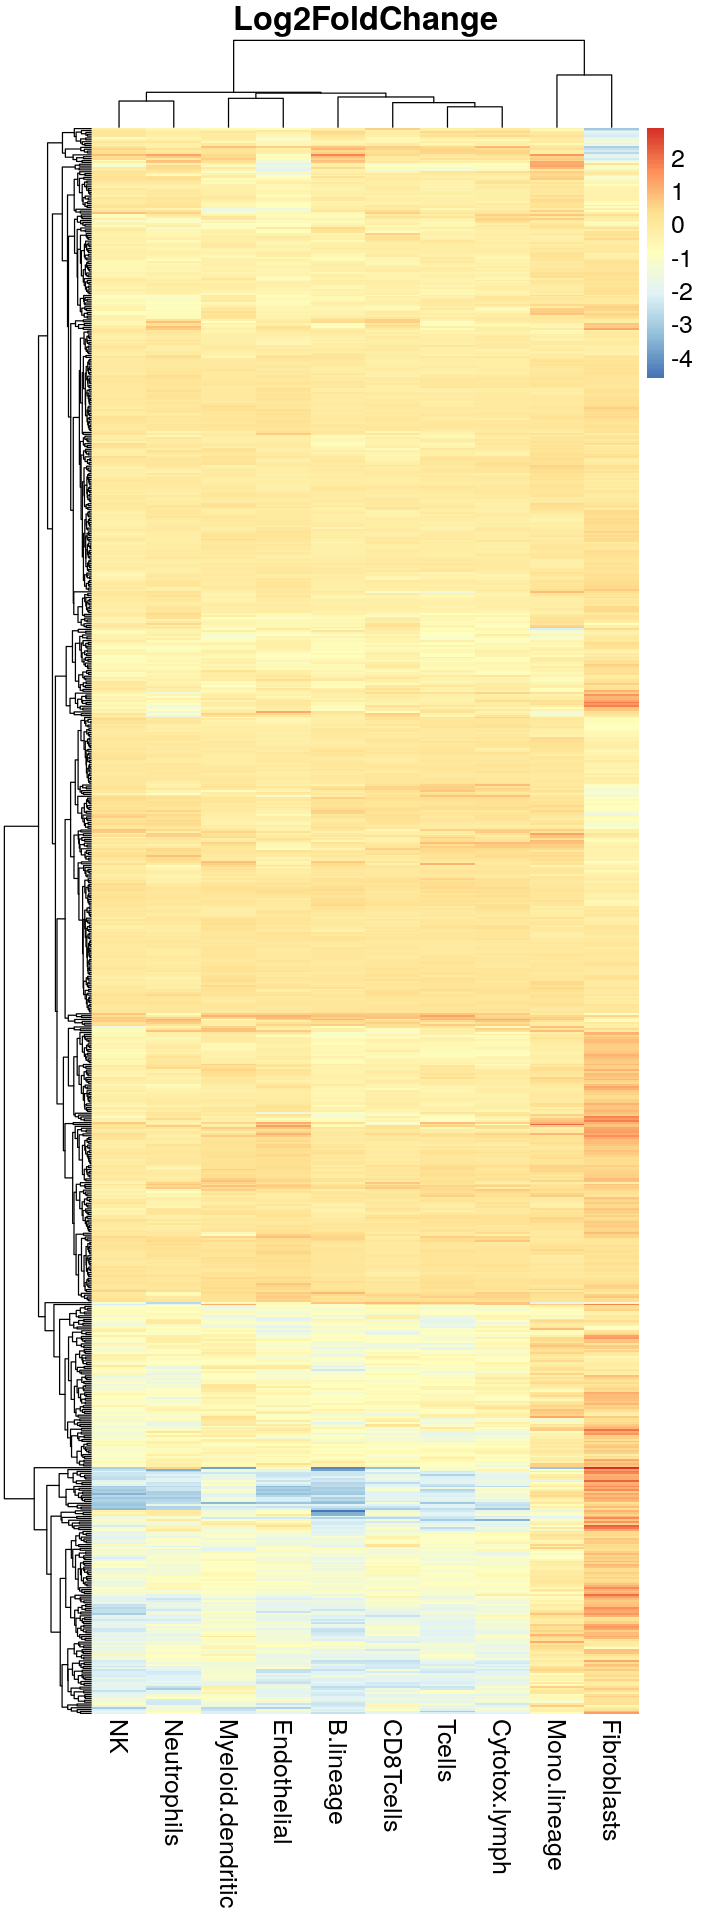

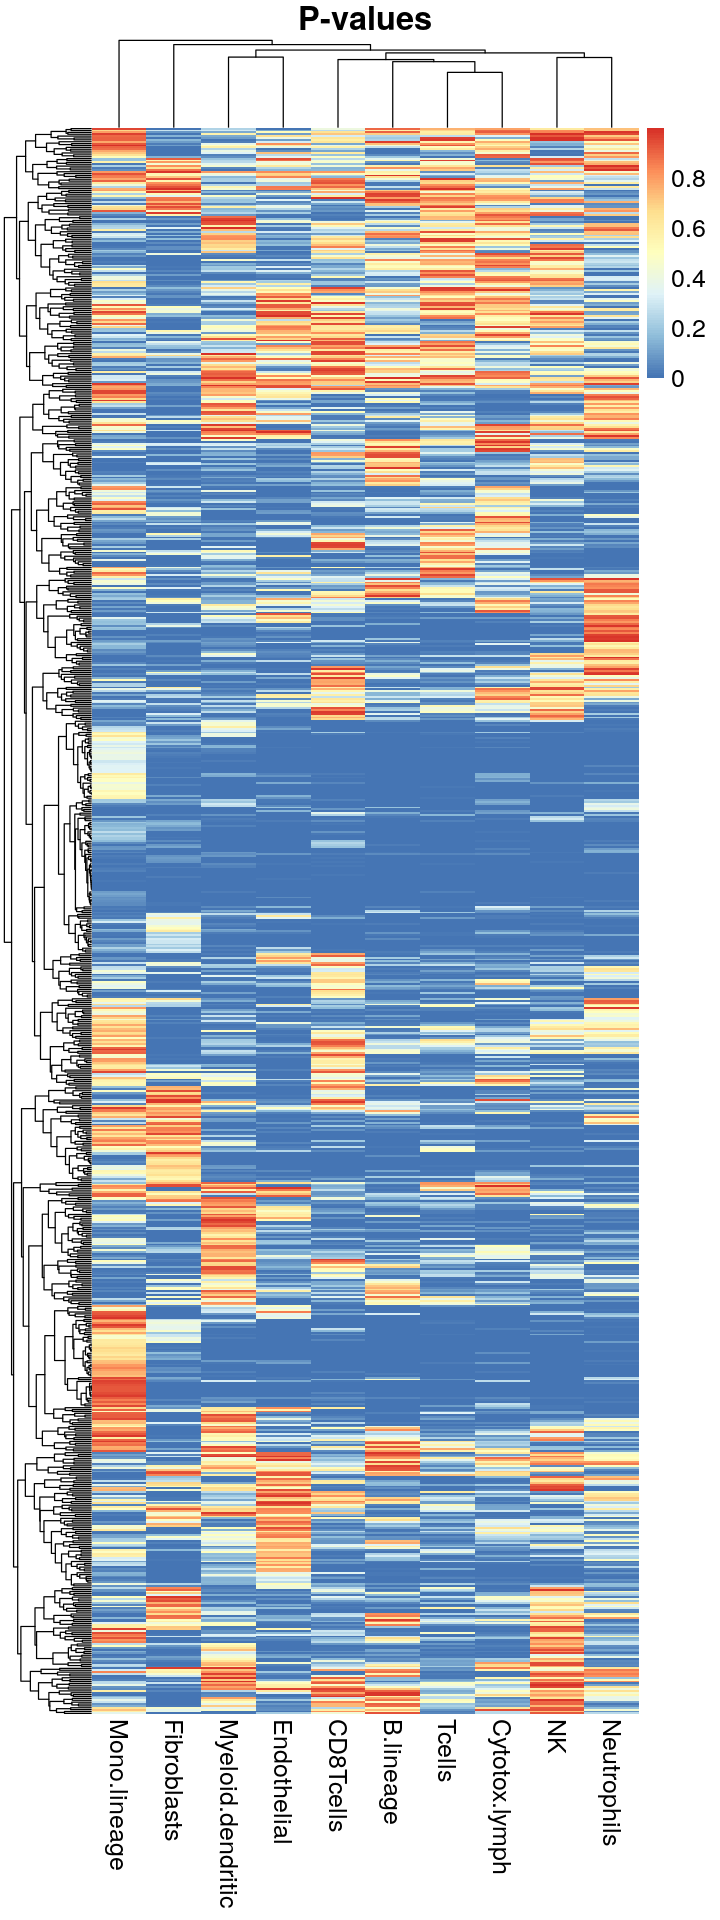

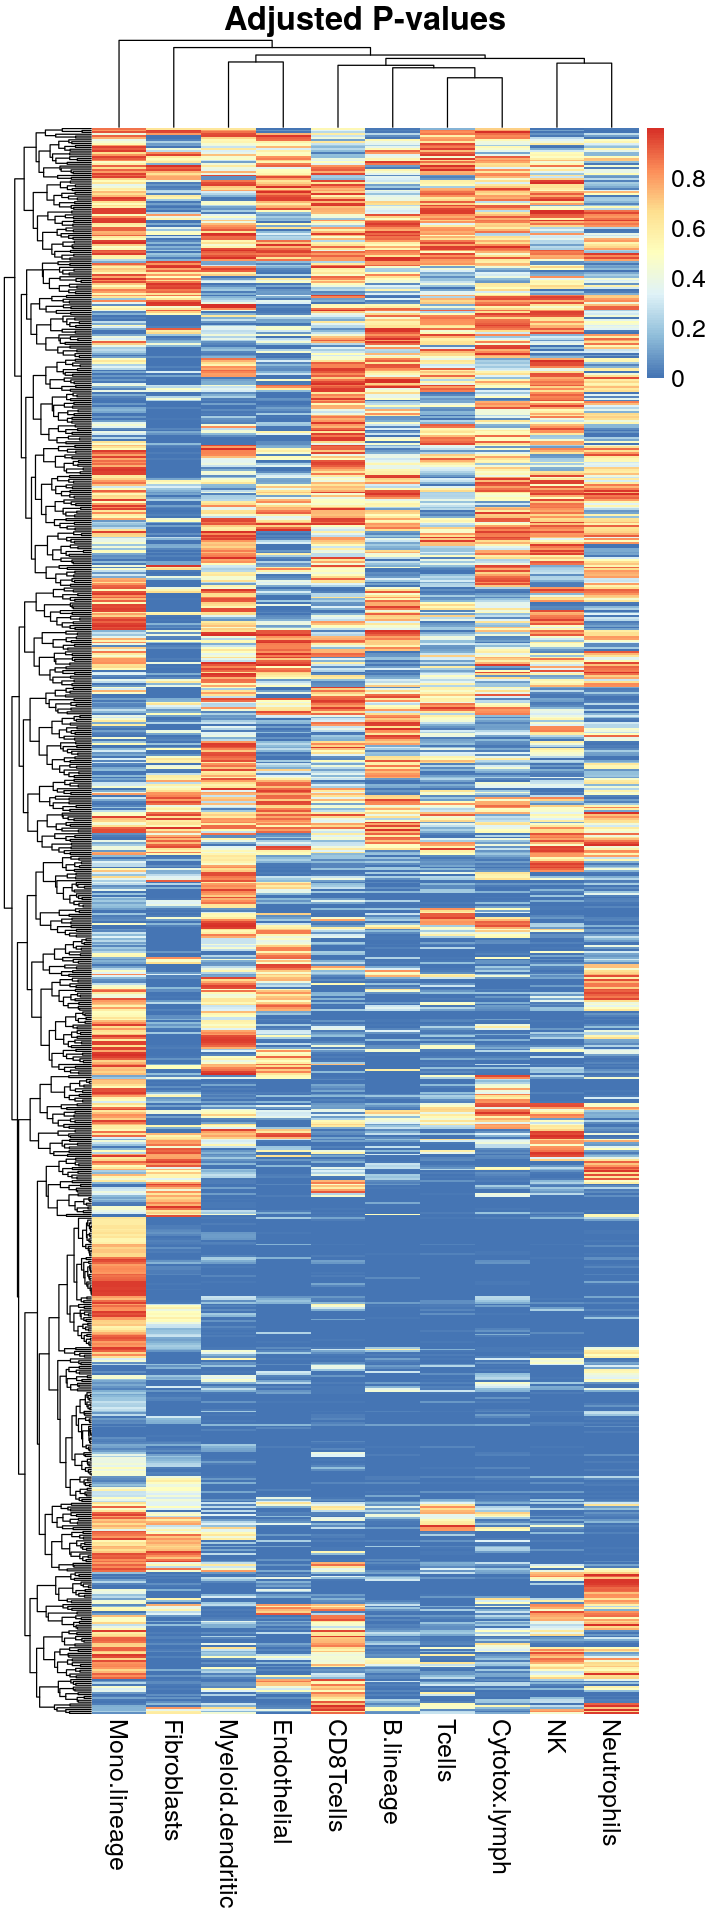

In [9]:
# Draw the heatmap of the log2FoldChange values
options(repr.plot.width = 6, repr.plot.height = 16)
par(mfrow = c(1, 3), mar = c(5, 4, 5, 1))

lfcs |>
  pheatmap(
    cluster_rows = TRUE,
    cluster_cols = TRUE,
    show_rownames = FALSE,
    show_colnames = TRUE,
    main = "Log2FoldChange",
    fontsize = 15
  )

pvalues |>
  pheatmap(
    cluster_rows = TRUE,
    cluster_cols = TRUE,
    show_rownames = FALSE,
    show_colnames = TRUE,
    main = "P-values",
    fontsize = 15
  )

padjs |>
  pheatmap(
    cluster_rows = TRUE,
    cluster_cols = TRUE,
    show_rownames = FALSE,
    show_colnames = TRUE,
    main = "Adjusted P-values",
    fontsize = 15
  )

In [23]:
# Transform the gene ids into gene symbols using the annotation table
gene_symbols_all <- geneannot$GeneName[match(rownames(res_all),
                                             geneannot$GeneID)]
# Get the matrisome genes that are in the counts matrix
matrisome_genes_all <- matrisome_genes[match(gene_symbols_all,
                                             matrisome_genes$Gene.Symbol) |> na.omit(), ]

# # Get the columns Matrisome Division,Matrisome Category,Gene Symbol,Gene Name
matrisome_genes_all <- matrisome_genes_all |>
  dplyr::select(Matrisome.Division, Matrisome.Category, Gene.Symbol, Gene.Name)

# Add the word Spearman to the column names of the correlations_matrisome
colnames(correlations_matrisome) <- paste("Spearman_",
                                          colnames(correlations_matrisome))

# Combine the correlations_matrisome and res_all data frames
table_all <- cbind(matrisome_genes_all, correlations_matrisome, res_all)

head(table_all)

,Matrisome.Division,Matrisome.Category,Gene.Symbol,Gene.Name,Spearman_ Tcells,Spearman_ CD8Tcells,Spearman_ Cytotox.lymph,Spearman_ NK,Spearman_ B.lineage,Spearman_ Mono.lineage,⋯,padj_Myeloid.dendritic,log2FoldChange_Neutrophils,pvalue_Neutrophils,padj_Neutrophils,log2FoldChange_Endothelial,pvalue_Endothelial,padj_Endothelial,log2FoldChange_Fibroblasts,pvalue_Fibroblasts,padj_Fibroblasts
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Core matrisome,ECM Glycoproteins,ABI3BP,"ABI family, member 3 (NESH) binding protein",0.04232965,0.07119000,0.05595842,0.074993678,0.10681724,-0.088882297,⋯,3.643974e-01,0.08786201,5.479366e-01,6.767217e-01,-0.26260911,7.268788e-02,1.378788e-01,0.2644812,6.842514e-02,1.239565e-01
2,Core matrisome,ECM Glycoproteins,ADIPOQ,"adiponectin, C1Q and collagen domain containing",0.14776386,0.09285416,0.16707413,0.137660640,0.12346238,0.113984539,⋯,2.822208e-06,-0.50981879,7.321520e-02,1.548502e-01,-1.50613447,1.700051e-07,2.025694e-06,-0.2364109,3.890345e-01,5.024781e-01
3,Core matrisome,ECM Glycoproteins,AEBP1,AE binding protein 1,0.04525759,0.02813788,0.04520286,0.074305392,0.07058241,-0.090904356,⋯,7.235792e-02,-0.28287185,9.856301e-02,1.971260e-01,-0.08336736,6.004722e-01,7.134825e-01,-0.3466115,2.847127e-02,5.928428e-02
4,Core matrisome,ECM Glycoproteins,AGRN,agrin,0.26051190,0.21839566,0.24413872,0.353908239,0.31964608,0.016465036,⋯,1.366752e-02,-2.92590756,6.199938e-13,2.622574e-11,-2.88398137,1.601959e-12,1.004569e-10,0.6903565,9.593310e-02,1.594487e-01
8,Core matrisome,ECM Glycoproteins,BGLAP,bone gamma-carboxyglutamate (gla) protein,0.08661666,0.13543016,0.12442037,0.237024066,0.14840143,-0.024642380,⋯,1.172314e-01,-1.22037812,9.807618e-09,1.659449e-07,-0.65313656,2.696972e-03,8.450513e-03,0.7086194,9.597678e-04,3.274047e-03
9,Core matrisome,ECM Glycoproteins,BMPER,BMP binding endothelial regulator,0.09432327,0.03406953,0.04711220,-0.006021444,0.15533720,-0.009269177,⋯,6.623878e-01,0.20100745,2.916628e-04,1.656019e-03,0.22542032,4.386094e-05,2.650454e-04,0.3337977,4.126416e-10,5.818246e-09


In [24]:
# Remove any colum containing Fibroblasts or Endothelial in colnames
table_all <- table_all[, !grepl("Fibroblasts|Endothelial", colnames(table_all))]

head(table_all)

,Matrisome.Division,Matrisome.Category,Gene.Symbol,Gene.Name,Spearman_ Tcells,Spearman_ CD8Tcells,Spearman_ Cytotox.lymph,Spearman_ NK,Spearman_ B.lineage,Spearman_ Mono.lineage,⋯,padj_B.lineage,log2FoldChange_Mono.lineage,pvalue_Mono.lineage,padj_Mono.lineage,log2FoldChange_Myeloid.dendritic,pvalue_Myeloid.dendritic,padj_Myeloid.dendritic,log2FoldChange_Neutrophils,pvalue_Neutrophils,padj_Neutrophils
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Core matrisome,ECM Glycoproteins,ABI3BP,"ABI family, member 3 (NESH) binding protein",0.04232965,0.07119000,0.05595842,0.074993678,0.10681724,-0.088882297,⋯,1.886753e-04,0.16248021,0.26609992,0.5166480,-0.18432137,2.080425e-01,3.643974e-01,0.08786201,5.479366e-01,6.767217e-01
2,Core matrisome,ECM Glycoproteins,ADIPOQ,"adiponectin, C1Q and collagen domain containing",0.14776386,0.09285416,0.16707413,0.137660640,0.12346238,0.113984539,⋯,6.537182e-01,-0.16653869,0.57049244,0.7709850,-1.54123421,8.673452e-08,2.822208e-06,-0.50981879,7.321520e-02,1.548502e-01
3,Core matrisome,ECM Glycoproteins,AEBP1,AE binding protein 1,0.04525759,0.02813788,0.04520286,0.074305392,0.07058241,-0.090904356,⋯,1.018533e-02,0.30177309,0.07818277,0.2468008,-0.38922972,2.232319e-02,7.235792e-02,-0.28287185,9.856301e-02,1.971260e-01
4,Core matrisome,ECM Glycoproteins,AGRN,agrin,0.26051190,0.21839566,0.24413872,0.353908239,0.31964608,0.016465036,⋯,9.285968e-12,0.40636105,0.33751629,0.5929855,-1.25384381,2.601029e-03,1.366752e-02,-2.92590756,6.199938e-13,2.622574e-11
8,Core matrisome,ECM Glycoproteins,BGLAP,bone gamma-carboxyglutamate (gla) protein,0.08661666,0.13543016,0.12442037,0.237024066,0.14840143,-0.024642380,⋯,9.894216e-05,0.18173046,0.40573103,0.6510489,-0.43881765,4.198715e-02,1.172314e-01,-1.22037812,9.807618e-09,1.659449e-07
9,Core matrisome,ECM Glycoproteins,BMPER,BMP binding endothelial regulator,0.09432327,0.03406953,0.04711220,-0.006021444,0.15533720,-0.009269177,⋯,9.337195e-02,0.03500159,0.53421998,0.7470250,0.03745091,5.063092e-01,6.623878e-01,0.20100745,2.916628e-04,1.656019e-03


In [25]:
# Save the table_all data frame
write.csv(table_all, "data/PDAC_MICRODISSEC_NAIF/results/PDAC_matrisome_corr_lfc_immuno.csv")

In [ ]:
# # Define the design matrix from the column names of the immuno counts
# design <- as.formula(paste("~",
#                            paste(colnames(immuno_counts),
#                                  collapse = " + ")))

# # Define the DESeq2 dataset
# dds <- DESeqDataSetFromMatrix(countData = cts,
#                               colData = coldata,
#                               design = ~ Tcells)
# dds